Source: https://global-surface-water.appspot.com/download

In [1]:
from rasterio.crs import CRS
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
from dem_stitcher.geojson_io import to_geojson_gzip
from tile_mate.tile_model import TILE_SCHEMA
from tile_mate.stitcher import DATA_DIR
import rasterio

# Generate Tiles

In [2]:
# box inputs are minx, miny, maxx, maxy
geometries = [box(-180 + i * 10, 
                  80 - (j + 1) * 10, 
                  -180 + (i + 1) * 10,
                  80 - (j) * 10) for i in range(36) for j in range(14)]

# Upper left corner
ul_corners = [(-180 + (i) * 10, 80 - (j) * 10) for i in range(36) for j in range(14)]
# data
df_peckel_data = gpd.GeoDataFrame(geometry=geometries, crs=CRS.from_epsg(4326))

<Axes: >

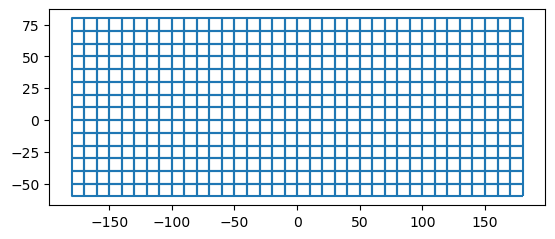

In [3]:
def url_generator(corner: tuple, 
                  layer: str ='last'):
    
    assert(layer in ['first', 'last', 'treecover2000'])
    
    base_url = 'https://storage.googleapis.com/global-surface-water/downloads2021/occurrence'
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):d}W'
    else:
        lon_str = f'{abs(lon):d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):d}N'
    else:
        lat_str = f'{abs(lat):d}S'
    return f'{base_url}/occurrence_{lon_str}_{lat_str}v1_4_2021.tif'

def tile_id_gen(corner: tuple[int]) -> str:
    lon, lat = corner
    if lon < 0:
        lon_str = f'{abs(lon):d}W'
    else:
        lon_str = f'{abs(lon):d}E'
    if lat >= 0:
        lat_str = f'{abs(lat):d}N'
    else:
        lat_str = f'{abs(lat):d}S'
    return f'{lon_str}_{lat_str}'

df_peckel_data['tile_id'] = list(map(tile_id_gen, ul_corners))
df_peckel_data['url'] = list(map(url_generator, ul_corners))
df_peckel_data.boundary.plot()

In [4]:
df_peckel_data.head()

,geometry,tile_id,url
0,"POLYGON ((-170.00000 70.00000, -170.00000 80.0...",180W_80N,https://storage.googleapis.com/global-surface-...
1,"POLYGON ((-170.00000 60.00000, -170.00000 70.0...",180W_70N,https://storage.googleapis.com/global-surface-...
2,"POLYGON ((-170.00000 50.00000, -170.00000 60.0...",180W_60N,https://storage.googleapis.com/global-surface-...
3,"POLYGON ((-170.00000 40.00000, -170.00000 50.0...",180W_50N,https://storage.googleapis.com/global-surface-...
4,"POLYGON ((-170.00000 30.00000, -170.00000 40.0...",180W_40N,https://storage.googleapis.com/global-surface-...


In [5]:
sample_url = df_peckel_data.url[0]
print(sample_url)

https://storage.googleapis.com/global-surface-water/downloads2021/occurrence/occurrence_180W_80Nv1_4_2021.tif


In [6]:
with rasterio.open(sample_url) as ds:
    p = ds.profile
p

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 40000, 'height': 40000, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00025, 0.0, -180.0,
       0.0, -0.00025, 80.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}

In [7]:
df_peckel_data = TILE_SCHEMA.validate(df_peckel_data)

# Serialize

In [8]:
to_geojson_gzip(df_peckel_data, str(DATA_DIR / 'pekel_water_occurrence_2021.geojson.zip'))

'/Users/cmarshak/bekaert-team/tile-mate/tile_mate/data/pekel_water_occurrence_2021.geojson.zip'